In [33]:
import pandas as pd
import numpy as np
import shap
import torch
from torch import nn
import scipy.stats
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import networkx as nx
import random
import os


from torch.distributions import Categorical, Bernoulli


import json

from agents.option_critic import OptionCriticFeatures
from agents.option_critic_nn import OptionCriticNeuralNetwork
from agents.option_networks import TerminationFunctionNetwork
from agents.option_networks import ReluNetwork

from utils import utils


In [ ]:
def to_tensor(obs):
    obs = np.asarray(obs)
    obs = torch.from_numpy(obs).float()
    return obs

def load_data(prefix):
    df_single_episode = pd.read_csv(f'{BASE_FOLDER}/{prefix}_1_episode.csv')
    df_single_episode = df_single_episode.set_index('step')
    df_single_episode = df_single_episode.drop(columns=['cumulative_reward'])
    
    df_multiple_episodes = None
    # df_multiple_episodes = pd.read_csv(f'{BASE_FOLDER}/{prefix}_100_episode.csv')
    # df_multiple_episodes = df_multiple_episodes.set_index('episode')
    # df_multiple_episodes = df_multiple_episodes.drop(columns=['cumulative_reward'])
    return df_single_episode, df_multiple_episodes


In [87]:
BASE_FOLDER = './evaluations'
N_OPTIONS = 10
TRAFFIC = "cologne8"
MODEL = f"option_critic_nn_{N_OPTIONS}_options_{TRAFFIC}_50400_steps"
PREFIX = f"{MODEL}_{TRAFFIC}"                                              

In [88]:
df_single_episode, _ = load_data(PREFIX)

model_params = torch.load(
    f"./models/{MODEL}"
)

q_model_params = model_params['Q']
termination_network_params = model_params['terminations']

termination_model = TerminationFunctionNetwork(obs_size=list(termination_network_params.values())[0].shape[1],
                                               n_options=list(termination_network_params.values())[-1].shape[0],
                                              device="cpu")
q_model = ReluNetwork(obs_size=list(q_model_params.values())[0].shape[1],
                      action_size=list(q_model_params.values())[-1].shape[0],
                      device="cpu")

/tmp/ipykernel_15233/638327299.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_params = torch.load(


<Axes: xlabel='step'>

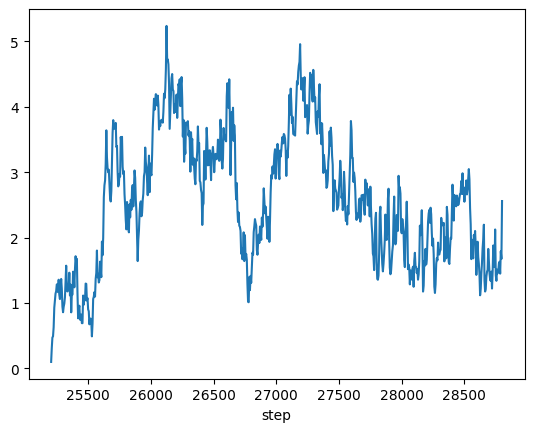

In [74]:
df_single_episode.lane_density.plot()

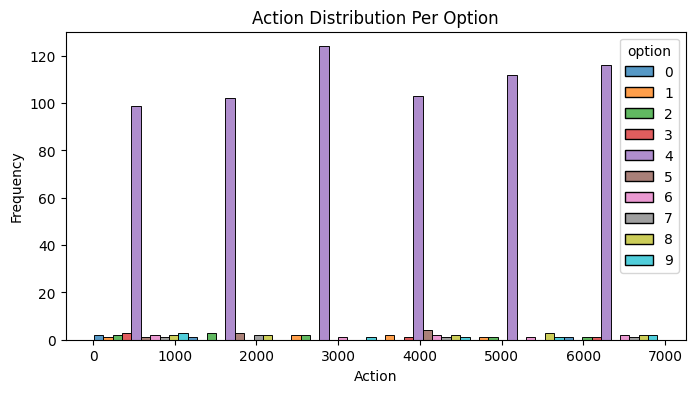

In [89]:
plt.figure(figsize=(8, 4))
sns.histplot(df_single_episode, x="action", hue="option", multiple="dodge", palette="tab10", bins=6)
plt.xlabel("Action")
plt.ylabel("Frequency")
plt.title("Action Distribution Per Option")
plt.show()

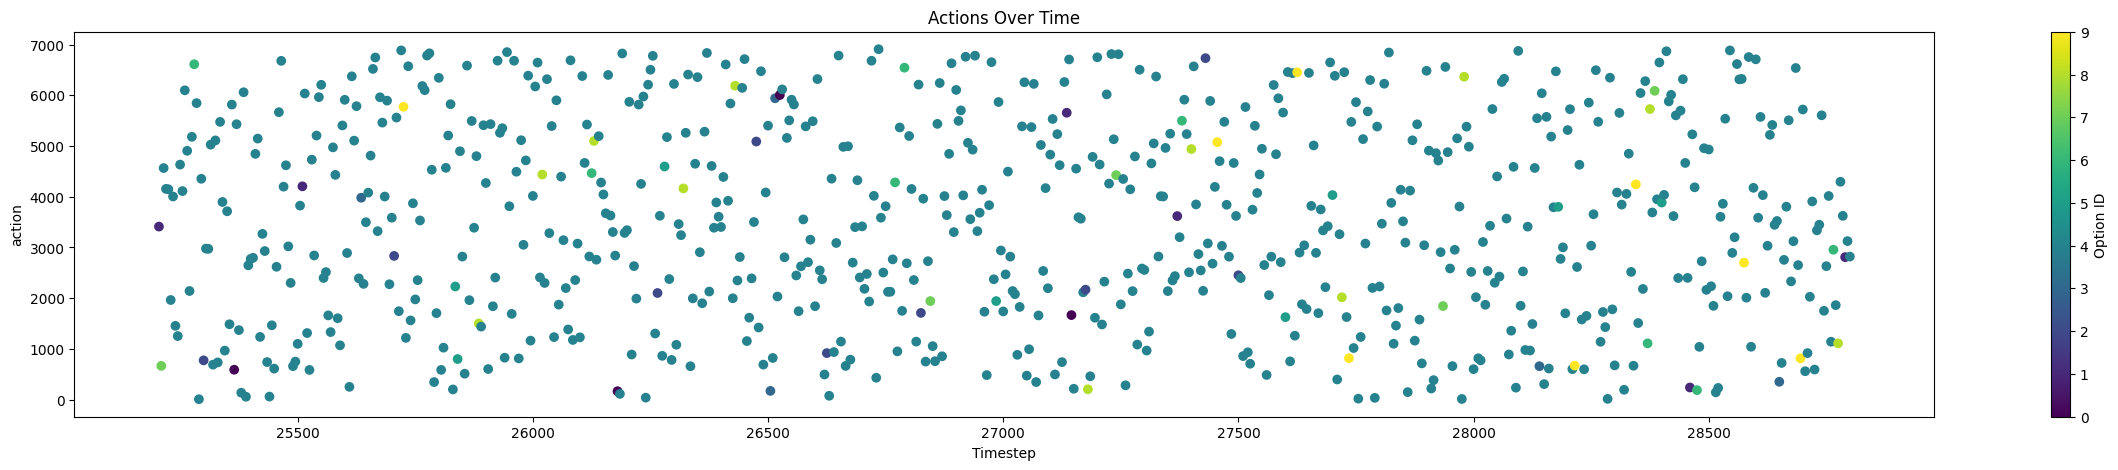

In [90]:
plt.figure(figsize=(30, 5))
plt.scatter(df_single_episode.index, df_single_episode.action, c=df_single_episode.option)
plt.xlabel("Timestep")
plt.ylabel("action")
plt.title("Actions Over Time")
plt.colorbar(label="Option ID")
plt.show()

In [66]:
def get_random_obs(df):
    current_option = df.option.to_list()[0]
    index = random.randrange(df.shape[0])
    total_observation = []
    unnested_obs = {}
    for tf_id, observation_dict in json.loads(df.obs.to_list()[index]).items():
    #   current_time = observation_dict["current_time"]
        phase_ids = observation_dict["phase_ids"]
        min_green = observation_dict["min_green"]
        density = observation_dict["density"]
        queue = observation_dict["queue"]
        delta_queue = observation_dict["delta_queue"]
        observation = phase_ids + min_green + density + queue + delta_queue
        total_observation.extend(observation)
        for key, value in observation_dict.items():
            if isinstance(value, list):
                for index, item in enumerate(value):
                    unnested_obs[f"{tf_id}_{key}_{index}"] = item
            else:
                unnested_obs[f"{tf_id}_{key}"] = value
    total_observation = np.array(total_observation, dtype=np.float32)
    return total_observation, current_option, unnested_obs

def prep_state(obs):
    """Convert the provided observation to a tensor

    Args:
        obs (Any): Obs provided by the environment
    """

    # Unnest observation
    obs_array = []
    if isinstance(obs, dict):
        for _, obs_arr in obs.items():
            obs_array.extend(obs_arr)
    else:
        obs_array.extend(obs)


    # include option information
    # Simplified to make it easier to manage
    # encoded_option = np.zeros(self.num_options)
    # encoded_option[self.current_option] = 1
    # obs = np.append(obs, encoded_option)

    # Convert to tensor
    obs_tensor = to_tensor(obs_array)
    if obs_tensor.ndim < 4:
        obs_tensor = obs_tensor.unsqueeze(0)
    obs_tensor = obs_tensor.to("cpu")
    return obs_tensor

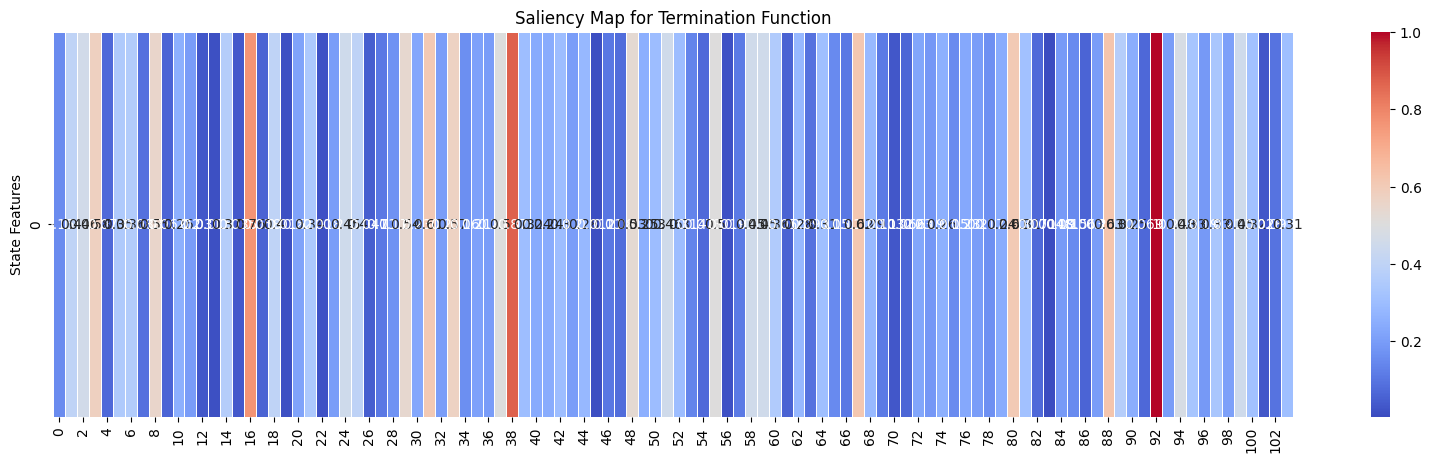

In [67]:
obs, current_option, unnested_dict = get_random_obs(df_single_episode)
state = prep_state(obs)
state = state.clone().detach().requires_grad_(True)
# Forward pass
termination_prob = termination_model(state)[:, current_option]

# Compute gradients w.r.t input state
termination_prob.backward()

# Get absolute gradient values (saliency)
saliency = state.grad.abs().detach().numpy()

# Normalize for visualization
saliency /= saliency.max()

# Plot saliency map
plt.figure(figsize=(20, 5))
sns.heatmap(saliency.reshape(1, -1), annot=True, cmap="coolwarm", cbar=True, linewidths=0.5)
plt.title("Saliency Map for Termination Function")
plt.ylabel("State Features")
plt.show()

In [68]:
for index, key in enumerate(unnested_dict):
    print(index, key)

0 360082_phase_ids_0
1 360082_phase_ids_1
2 360082_phase_ids_2
3 360082_phase_ids_3
4 360082_phase_ids_4
5 360082_phase_ids_5
6 360082_phase_ids_6
7 360082_phase_ids_7
8 360082_phase_ids_8
9 360082_phase_ids_9
10 360082_phase_ids_10
11 360082_phase_ids_11
12 360082_min_green_0
13 360082_density_0
14 360082_density_1
15 360082_density_2
16 360082_density_3
17 360082_density_4
18 360082_queue_0
19 360082_queue_1
20 360082_queue_2
21 360082_queue_3
22 360082_queue_4
23 360082_delta_queue_0
24 360082_delta_queue_1
25 360082_delta_queue_2
26 360082_delta_queue_3
27 360082_delta_queue_4
28 360086_phase_ids_0
29 360086_phase_ids_1
30 360086_phase_ids_2
31 360086_phase_ids_3
32 360086_phase_ids_4
33 360086_phase_ids_5
34 360086_phase_ids_6
35 360086_phase_ids_7
36 360086_phase_ids_8
37 360086_phase_ids_9
38 360086_phase_ids_10
39 360086_phase_ids_11
40 360086_phase_ids_12
41 360086_phase_ids_13
42 360086_phase_ids_14
43 360086_phase_ids_15
44 360086_min_green_0
45 360086_density_0
46 360086_de

In [77]:
for _ in range(100):
    obs, current_option, unnested_dict = get_random_obs(df_single_episode)
    state = prep_state(obs)
    print(q_model(state))

tensor([[-0.0041, -0.0398,  0.0116,  0.0423,  0.0950, -0.0520, -0.0149, -0.0479,
         -0.0788, -0.0573]], grad_fn=<AddmmBackward0>)
tensor([[ 1.0207e-04, -2.2385e-02,  1.5841e-02,  4.4608e-02,  7.8730e-02,
         -9.8304e-02, -6.9151e-02, -4.0926e-02, -1.0878e-01, -5.2493e-02]],
       grad_fn=<AddmmBackward0>)
tensor([[ 0.0066,  0.0425,  0.0281,  0.0490,  0.0939, -0.0768, -0.0136, -0.0105,
         -0.1144, -0.0233]], grad_fn=<AddmmBackward0>)
tensor([[-0.0216, -0.0390, -0.0326,  0.0423,  0.0329, -0.0705, -0.0437, -0.0593,
         -0.0437, -0.0793]], grad_fn=<AddmmBackward0>)
tensor([[ 0.0542,  0.0168, -0.0368,  0.0756,  0.1159, -0.1072,  0.0099, -0.0256,
         -0.0336, -0.0273]], grad_fn=<AddmmBackward0>)
tensor([[-0.0497, -0.0045,  0.0606,  0.0331,  0.0766, -0.0384, -0.0874, -0.0519,
         -0.1258, -0.0208]], grad_fn=<AddmmBackward0>)
tensor([[ 0.0150, -0.0351,  0.0109,  0.0359,  0.1153, -0.1020, -0.0178, -0.1086,
         -0.0958, -0.0614]], grad_fn=<AddmmBackward0>)
t

In [71]:
def create_feature_df(df):
    feature_list = []
    for obs_item in df.obs.to_list():
        unnested_obs = {}
        for tf_id, observation_dict in json.loads(obs_item).items():
            for key, value in observation_dict.items():
                if isinstance(value, list):
                    for index, item in enumerate(value):
                        unnested_obs[f"{tf_id}_{key}_{index}"] = item
                else:
                    unnested_obs[f"{tf_id}_{key}"] = value
                    
        feature_list.append(unnested_obs)
    return pd.DataFrame(feature_list)

features = create_feature_df(df_single_episode)

def f(X):
    results = []
    for record in X:
        record = to_tensor([record])
        state = prep_state(record)
        prob = termination_model(state).sigmoid()
        max_prob = np.max(prob.detach().numpy())
        results.append(max_prob)
    return np.array(results)
explainer = shap.KernelExplainer(f, features.iloc[:50, :])
shap_values = explainer.shap_values(features.iloc[:, :], nsamples=50)

  0%|▍                                                                                                             | 3/720 [00:02<11:29,  1.04it/s]/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=2.278e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=1.011e-03, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/linear_model/_least_an

  2%|█▉                                                                                                           | 13/720 [00:21<21:58,  1.86s/it]/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=7.159e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:755: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 61 iterations, alpha=1.445e-03, previous alpha=1.445e-03, with an active set of 20 regressors.
  warnings.warn(
  2%|██                                                                                                           | 14/

  3%|███                                                                                                          | 20/720 [00:30<15:34,  1.33s/it]/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=8.002e-03, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 32 iterations, i.e. alpha=2.219e-03, with an active set of 16 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/linear_model/_least_

  5%|█████▎                                                                                                       | 35/720 [00:45<11:49,  1.04s/it]/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 36 iterations, i.e. alpha=5.985e-05, with an active set of 22 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 36 iterations, i.e. alpha=5.981e-05, with an active set of 22 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/linear_model/_leas

  6%|██████▊                                                                                                      | 45/720 [00:58<17:47,  1.58s/it]/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 13 iterations, i.e. alpha=6.060e-04, with an active set of 13 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:755: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 25 iterations, alpha=4.558e-04, previous alpha=4.345e-04, with an active set of 22 regressors.
  warnings.warn(
  6%|██████▉                                                                                                      | 4

  8%|████████▊                                                                                                    | 58/720 [01:15<16:02,  1.45s/it]/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=9.121e-04, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 10 iterations, i.e. alpha=6.657e-04, with an active set of 10 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/linear_model/_least_

 10%|██████████▍                                                                                                  | 69/720 [01:27<12:07,  1.12s/it]/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=2.481e-03, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 20 iterations, i.e. alpha=1.071e-03, with an active set of 14 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/linear_model/_least_

 11%|████████████▍                                                                                                | 82/720 [01:43<13:18,  1.25s/it]/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 37 iterations, i.e. alpha=8.073e-06, with an active set of 25 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 38 iterations, i.e. alpha=6.079e-06, with an active set of 26 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/linear_model/_leas

 13%|██████████████▋                                                                                              | 97/720 [02:00<11:15,  1.08s/it]/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 12 iterations, i.e. alpha=6.184e-04, with an active set of 12 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:755: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 25 iterations, alpha=3.306e-04, previous alpha=2.992e-04, with an active set of 20 regressors.
  warnings.warn(
 14%|██████████████▊                                                                                              | 9

 15%|███████████████▉                                                                                            | 106/720 [02:09<10:47,  1.06s/it]/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/shap/explainers/_kernel.py:707: UserWarning: Linear regression equation is singular, a least squares solutions is used instead.
To avoid this situation and get a regular matrix do one of the following:
1) turn up the number of samples,
2) turn up the L1 regularization with num_features(N) where N is less than the number of samples,
3) group features together to reduce the number of inputs that need to be explained.
  warnings.warn(
 15%|████████████████                                                                                            | 107/720 [02:10<10:30,  1.03s/it]/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 2 iterations, i.e

 17%|██████████████████▊                                                                                         | 125/720 [02:29<10:11,  1.03s/it]/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=1.297e-03, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:755: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 33 iterations, alpha=2.716e-04, previous alpha=1.944e-04, with an active set of 24 regressors.
  warnings.warn(
 18%|██████████████████▉                                                                                         | 126/

 18%|███████████████████▊                                                                                        | 132/720 [02:36<08:51,  1.11it/s]/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 29 iterations, i.e. alpha=8.639e-05, with an active set of 19 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 30 iterations, i.e. alpha=6.868e-05, with an active set of 20 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/linear_model/_leas

 20%|██████████████████████                                                                                      | 147/720 [02:59<25:39,  2.69s/it]/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=1.612e-03, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=9.965e-04, with an active set of 13 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/linear_model/_least_

 22%|████████████████████████                                                                                    | 160/720 [03:15<10:45,  1.15s/it]/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 38 iterations, i.e. alpha=5.448e-05, with an active set of 22 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:755: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 41 iterations, alpha=4.407e-05, previous alpha=4.174e-05, with an active set of 22 regressors.
  warnings.warn(
 22%|████████████████████████▏                                                                                   | 16

 24%|█████████████████████████▋                                                                                  | 171/720 [03:29<12:42,  1.39s/it]/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=1.937e-03, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/linear_model/_least_angle.py:725: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 17 iterations, i.e. alpha=1.040e-03, with an active set of 15 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/ruben/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/linear_model/_least_

ValueError: operands could not be broadcast together with shapes (78,) (77,) 

In [27]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, features)

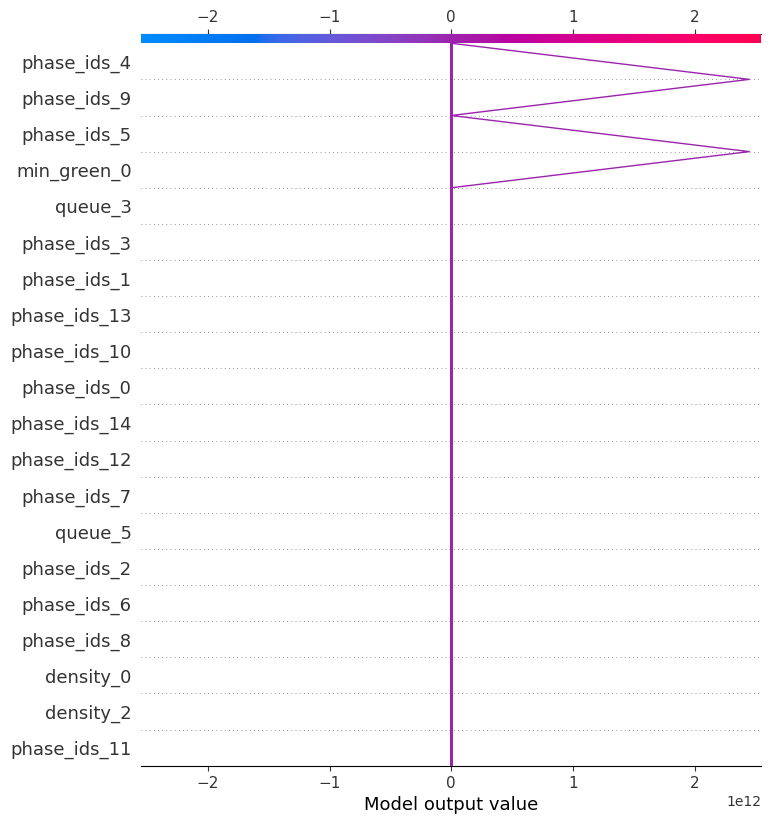

In [28]:
shap.initjs()
shap.decision_plot(explainer.expected_value, shap_values, features)

In [ ]:
##########
# Backup #
##########

In [ ]:
states = df_single_episode.obs.to_list()
options = df_single_episode.option.to_list()
n = df_single_episode.shape[0]
G = nx.DiGraph()

# Add nodes with positions
node_colors = []
for i in range(n):
    G.add_node(states[i], option=options[i])
    node_colors.append(options[i])

# Add directed edges based on actions
for i in range(n - 1):
    G.add_edge(i, i + 1, action=i)

# Draw graph
plt.figure(figsize=(8, 6))
print("Drawing graph")
nx.draw(
    G, with_labels=True,cmap=plt.cm.viridis,
    edge_color="gray", node_size=300, font_size=8, font_color="white",
    arrows=True, arrowsize=10
)

sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis)

plt.title("State-Action Network with Termination States")
plt.show()

In [ ]:
model_params = torch.load(
    f"./models/{MODEL}"
)

q_model_params = {}
termination_network_params = {}

for key, value in model_params.items():
    if key.startswith('Q'):
        q_model_params[key] = value
    elif key.startswith("terminations"):
        termination_network_params[key] = value
    else:
        print(f"Unknown key {key}")

termination_model = TerminationFunctionNetwork(obs_size=list(termination_network_params.values())[0].shape[1],
                                               n_options=list(termination_network_params.values())[-1].shape[0],
                                              device="cpu")
q_model = ReluNetwork(obs_size=list(q_model_params.values())[0].shape[1],
                      action_size=list(q_model_params.values())[-1].shape[0],
                      device="cpu")